In [10]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tqdm

This file aims to create TTV signals to validate higher MMR code with regimes
- Eccentricities: 0.01 to 0.1 / Uniform log e
- Longitudes of periastron: 0 to 360 deg / Uniform w
- MMRs: 3:1, 5:3, 7:5, 4:1, 5:2, 5:1 / Uniform
- Deltas: [-0.010, -0.005] union [0.005, 0.010] / Uniform
- Planet masses: 0.3 to 3000 Earth masses / Uniform log m

In [26]:
# Create 100k samples
size = 100000
mstar = 1

e1 = 10 ** np.random.uniform(low=-2, high=-1, size=size)
e2 = 10 ** np.random.uniform(low=-2, high=-1, size=size)
w1 = np.random.uniform(low=0, high=360, size=size)
w2 = np.random.uniform(low=0, high=360, size=size)

mmr = np.random.choice(['3:1', '5:3', '7:5', '4:1', '5:2', '5:1'], size=size)
mmrparts = np.char.split(mmr, ':')  # Extract j:j-N
j = np.array([int(p[0]) for p in mmrparts])
N = np.array([int(p[0]) - int(p[1]) for p in mmrparts])

Delta = np.random.uniform(low=0.005, high=0.010, size=size) * np.random.choice([-1, 1], size=size)
P1 = 7
P2 = P1 * (Delta + 1) * j / (j-1)

m1 = 10 ** np.random.uniform(low=-0.5, high=3.5, size=size)
m2 = 10 ** np.random.uniform(low=-0.5, high=3.5, size=size)

mu1 = (m1 * u.M_earth).to(mstar * u.M_sun).value
mu2 = (m2 * u.M_earth).to(mstar * u.M_sun).value

validity1 = Delta**2 / (mu1 * e1)
validity2 = Delta**2 / (mu2 * e2)
validity_threshold = 100

# Create valid mask
valid = (validity1 > validity_threshold) & (validity2 > validity_threshold)
valid_percent = valid.mean() * 100

# Compile to dataframe
df = pd.DataFrame({
    'e1': e1, 'w1': w1,
    'e2': e2, 'w2': w2,
    'Delta': Delta,
    'mmr': mmr, 'j': j, 'N': N,
    'P1': 7, 'P2': P2,
    'm1': m1, 'm2': m2,
    'mu1': mu1, 'mu2': mu2,
    'validity1': validity1, 'validity2': validity2,
    'valid': valid
})
df.head()

,e1,w1,e2,w2,Delta,mmr,j,N,P1,P2,m1,m2,mu1,mu2,validity1,validity2,valid
0,0.055991,58.822607,0.011141,50.888669,0.009918,7:5,7,2,7,8.247662,28.078984,0.545483,0.000084,0.000002,20.830953,5388.995909,False
1,0.087637,344.470331,0.035670,211.719067,0.007174,5:3,5,2,7,8.812771,79.232159,2574.401472,0.000238,0.007732,2.467673,0.186594,False
2,0.010202,48.065318,0.062583,220.054708,0.005091,5:1,5,4,7,8.794550,0.406798,25.491641,0.000001,0.000077,2079.712544,5.409987,False
3,0.031152,19.671023,0.027803,238.240708,0.005387,3:1,3,2,7,10.556567,156.776308,0.681225,0.000471,0.000002,1.978549,510.191044,False
4,0.086873,100.393352,0.031076,68.805124,0.008759,4:1,4,3,7,9.415083,129.163089,0.523876,0.000388,0.000002,2.276392,1568.974627,False


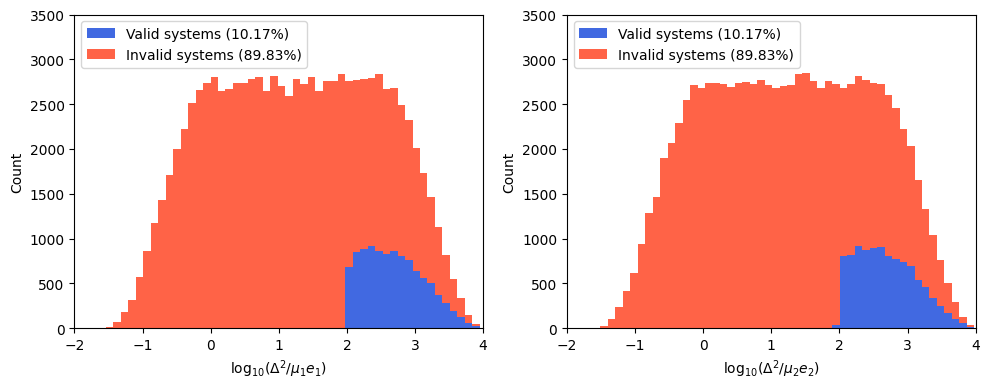

In [27]:
# Histogram of validity condition
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fmt = lambda x: f"{x:.2f}".rstrip("0").rstrip(".")
labels = [f"Valid systems ({fmt(valid_percent)}%)", f"Invalid systems ({fmt(100-valid_percent)}%)"]
colors = ["royalblue", "tomato"]
xlim = (-2, 4); ylim = (0, 3500)

# Left histogram
ax[0].hist([np.log10(validity1[valid]), np.log10(validity1[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[0].set_xlabel('log$_{10}$($\Delta^2 / \mu_1 e_1$)')
ax[0].set_ylabel('Count')
ax[0].set_xlim(xlim); ax[0].set_ylim(ylim)
ax[0].legend(loc='upper left')

# Right histogram
ax[1].hist([np.log10(validity2[valid]), np.log10(validity2[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[1].set_xlabel('log$_{10}$($\Delta^2 / \mu_2 e_2$)')
ax[1].set_ylabel('Count')
ax[1].set_xlim(xlim); ax[1].set_ylim(ylim)
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
# Export dataframe
df.to_csv("deckagol_TTVFast_params.csv", index=False)